In [115]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from collections import defaultdict
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
import os

In [123]:
class Vehicle:
    _id_counter = 0
    """Define vehicle attributes and rules to be implemented"""
    def __init__(self, x_position, speed, max_speed, length, width, road_designation, vehicle_type, current_row, lane_changing_prob):
        self.vehicle_id = Vehicle._id_counter  # Assign a unique ID to each vehicle
        Vehicle._id_counter += 1  #Increment the counter for the next vehicle
        self.x_position = x_position #position along the length of the road (x position)
        self.speed = speed #number of cells the vehicle will move per timestep
        self.max_speed = max_speed #maximum speed
        self.braking_prob = 0.01 #probability of random slowdown
        self.length = length #length of the vehicle is the number of cells the vehicle occupies along the length of the road
        self.width = width #width of the vehicle is the number of cells the vehicle occupies along the width of the road
        self.road_designation = road_designation #whether inside or outside
        self.vehicle_type = vehicle_type #type of vehicle is determined by the size and behavior
        self.current_row = current_row #also known as the y position of the right side of the vehicle
        self.lane_changing_prob = lane_changing_prob #probability that a vehicle will transfer lane
        
    def accelerate(self):
        """Increases vehicle's speed by 1 cell, up to the maximum speed"""
        if self.speed < self.max_speed:
            self.speed += 1

    def gap_distance(self, vehicle_row_to_be_checked): 
        """Debugging this - make gap distance consider toroidal boundary cond. recently introduced"""
        rear_bumper_position = self.x_position
        front_bumper_position = rear_bumper_position + self.length
        max_distance = self.speed #maximum distance checked is equivalent to speed
        road_length = self.road_designation.road_length
        
        gap_distance_row_1 = max_distance
        gap_distance_row_2 = max_distance
        
        for distance in range(1, max_distance + 1):
            next_rear_bumper_position = (rear_bumper_position + distance)  % road_length
            next_front_bumper_position = (front_bumper_position + distance)  % road_length

            # Check if there's an occupied space within the distance
            if next_rear_bumper_position < next_front_bumper_position:
                if np.sum(self.road_designation.road_occupancy[next_rear_bumper_position:next_front_bumper_position, vehicle_row_to_be_checked]) > 0:
                    gap_distance_row_1 = distance - 1
                    break
            else:  # Wrap-around case
                if np.sum(self.road_designation.road_occupancy[next_rear_bumper_position:, vehicle_row_to_be_checked]) > 0 or \
                   np.sum(self.road_designation.road_occupancy[:next_front_bumper_position, vehicle_row_to_be_checked]) > 0:
                    gap_distance_row_1 = distance - 1
                    break
                    
        for distance in range(1, max_distance + 1):
            next_rear_bumper_position = (rear_bumper_position + distance) % road_length
            next_front_bumper_position = (front_bumper_position + distance) % road_length

            if next_rear_bumper_position < next_front_bumper_position:
                if np.sum(self.road_designation.road_occupancy[next_rear_bumper_position:next_front_bumper_position, vehicle_row_to_be_checked]) > 0:
                    gap_distance_row_2 = distance - 1
                    break
            else:  # Wrap-around case
                if np.sum(self.road_designation.road_occupancy[next_rear_bumper_position:, vehicle_row_to_be_checked]) > 0 or \
                   np.sum(self.road_designation.road_occupancy[:next_front_bumper_position, vehicle_row_to_be_checked]) > 0:
                    gap_distance_row_2 = distance - 1
                    break
                
        if min(gap_distance_row_1, gap_distance_row_2) < 0:
            print(gap_distance_row_1, gap_distance_row_2, current_x_position) #Results to negative headway distance
        return max(0, min(gap_distance_row_1, gap_distance_row_2))  # Return the minimum gap distance

    def lane_changing(self, gap_distance):
        """attempts to change lanes based on vehicle type and lane availability
        Here, we define a lane as a space of 2 cells wide. We assume a two-lane road(4 cells wide, with 1 cell wide passenger holding area beside row 0).
        We assume that each half lane is an array, imagine a vertical stack of arrays, indexing is from top to bottom (0-4). Right side is the bottom."""
        new_row = self.current_row
        if self.speed > gap_distance:
            if self.current_row == 0: #There are specific cases wherein changing to the right or left lane is possible/legal
                new_lane = self.current_row + 1
            elif self.current_row == 2 : #This is slightly hardcoded. 
                new_lane = self.current_row - 1
            elif self.current_row == 1 and self.gap_distance(0)>self.gap_distance(2):
                new_lane = self.current_row - 1
            elif self.current_row == 1 and  self.gap_distance(0)<self.gap_distance(2):
                new_lane = self.current_row + 1
        # Check for space on the new lane
        if self.road_designation.road_occupancy[self.x_position:self.x_position + self.length, new_row:new_row + self.width].sum() == 0:
            self.current_row = new_row

    def decelerate(self, gap_distance):
        """decreases vehicle's speed to match the gap distance, given the speed>gap distance"""
        if self.speed > gap_distance:
            self.speed = gap_distance

    def braking(self):
        """Mimics random slowdown, randomly decreases vehicle's speed based on braking probability """
        if np.random.rand() < self.braking_prob and self.speed > 0:
            self.speed -= 1

    def move(self):
        """implements movement"""
        new_position = (self.x_position + self.speed) % self.road_designation.road_length
        self.x_position = new_position

In [124]:
class Road:
    def __init__(self, road_length, road_width, speed_limit):
        self.road_length = road_length
        self.road_width = road_width
        self.speed_limit = speed_limit
        self.road_occupancy = np.zeros((road_length, road_width))

In [130]:
class IntraRoadSimulator:
    def __init__(self, road):
        """This method stores the input agents and initializes output data"""
        self.road = road  # Store the road instance
        self.vehicles = []  # List to store vehicle instances
        self.occupancy_history = []  # List to store the history of road occupancy states
        self.vehicle_throughput = 0


    def update_occupancy(self):
        """This method updates road occupancy based on vehicle position and length"""
        self.road.road_occupancy.fill(0)
        for vehicle in self.vehicles:
            x_start = vehicle.x_position
            x_end = (vehicle.x_position + vehicle.length) % self.road.road_length #from vehicle rear bumper(position|) to front, minus 1. takes account of toroidal boundaries
            y_start = vehicle.current_row
            y_end = min(vehicle.current_row + vehicle.width, self.road.road_width)
            if x_start < x_end:
                if vehicle.vehicle_type == "jeep":
                    self.road.road_occupancy[x_start:x_end, y_start:y_end] = 1
                else:
                    self.road.road_occupancy[x_start:x_end, y_start:y_end] = 2
            else:
                if vehicle.vehicle_type == "jeep":
                    self.road.road_occupancy[x_start:, y_start:y_end] = 1
                    self.road.road_occupancy[:x_end, y_start:y_end] = 1
                else:
                    self.road.road_occupancy[x_start:x_end, y_start:y_end] = 2
        self.occupancy_history.append(self.road.road_occupancy.copy())

    def initialize_vehicles(self, density, truck_fraction, truck_lane_change_prob, jeep_lane_change_prob):
        A, B = 7 * 2, 3 * 2  # Constants for truck and jeep area
        L, W = self.road.road_length, self.road.road_width  # Road dimensions
        N = int(density * L * W * (truck_fraction / A + (1 - truck_fraction) / B))  # Number of vehicles based on density and truck fraction
        
        for _ in range(N):
            vehicle_type = 'truck' if np.random.rand() < truck_fraction else 'jeep'  # Randomly decide vehicle type
            length = 7 if vehicle_type == 'truck' else 3
            width = 2
            x_position = np.random.randint(0, self.road.road_length)  # Random initial position
            speed = np.random.randint(1, self.road.speed_limit + 1)
            lane_changing_prob = truck_lane_change_prob if vehicle_type == 'truck' else jeep_lane_change_prob
            current_row = 2 if vehicle_type == 'truck' else 0

            x_start = x_position
            x_end = (x_position + length) % self.road.road_length

            #Checking for overlap considering toroidal boundaries
            if (x_start < x_end and self.road.road_occupancy[x_start:x_end, current_row:current_row + width].sum() == 0) or \
               (x_start > x_end and (self.road.road_occupancy[x_start:, current_row:current_row + width].sum() == 0 and
                                     self.road.road_occupancy[:x_end, current_row:current_row + width].sum() == 0)):
                #Safe to add vehicle
                new_vehicle = Vehicle(x_position, speed, self.road.speed_limit, length, width, self.road, vehicle_type, current_row, lane_changing_prob)
                self.vehicles.append(new_vehicle)  # Add vehicle to the list
                if new_vehicle.vehicle_type == "jeep":
                    self.road.road_occupancy[x_position:x_position + length, current_row:current_row + width] = 1
                else:
                    self.road.road_occupancy[x_position:x_position + length, current_row:current_row + width] = 2 # Mark vehicle position on road occupancy grid
                        
    def record_throughput(self, vehicle):
        self.vehicle_throughput += 1

    def simulation_step(self):
        for vehicle in self.vehicles:
            gap_distance_of_own_lane = vehicle.gap_distance(vehicle.current_row)  # Calculate gap distance in current lane
            vehicle.accelerate()  # Accelerate the vehicle
            
            if vehicle.speed > gap_distance_of_own_lane:
                other_row = 2 if vehicle.current_row == 0 else 0
                gap_distance_of_other_lane = vehicle.gap_distance(other_row)  # Calculate gap distance in other lane
                if gap_distance_of_other_lane > gap_distance_of_own_lane:
                    if np.random.rand() < vehicle.lane_changing_prob:
                        #print(f"Vehicle {vehicle.vehicle_id} changing lanes")
                        vehicle.lane_changing(gap_distance_of_own_lane)  # Change lane if possible
                        vehicle.decelerate(gap_distance_of_own_lane)
                        # Decelerate if necessary
                    else:
                        #print(f"Vehicle {vehicle.vehicle_id} decelerating in own lane")
                        vehicle.decelerate(gap_distance_of_own_lane)  # Decelerate if not changing lanes
            # Apply brakes
            vehicle.braking()    
            """if vehicle.x_position == self.road.road_length - vehicle.length: #Greatest fix: redundant +speed and -length on position and road length sides, respectively
                #print(f"Vehicle {vehicle.vehicle_id} reached end of road at position {vehicle.x_position}")
                self.record_throughput(vehicle)"""


            # Move the vehicle and update road occupancy in real-time
            previous_position = vehicle.x_position
            vehicle.move()
        
        # Update road occupancy immediately to prevent overlaps
        self.road.road_occupancy[previous_position:previous_position + vehicle.length, vehicle.current_row:vehicle.current_row + vehicle.width] = 0
        self.road.road_occupancy[vehicle.x_position:vehicle.x_position + vehicle.length, vehicle.current_row:vehicle.current_row + vehicle.width] = 1

            if vehicle.speed < gap_distance_of_own_lane:
                print(vehicle.gap_distance, gap_distance_of_own_lane, vehicle.speed)
            if gap_distance_of_own_lane < 0:
                print(f"Vehicle {vehicle.vehicle_id} invalid")
            vehicle.move()  # Move the vehicle
            print(f"Vehicle {vehicle.vehicle_id} is at position {vehicle.x_position}, with a speed of {vehicle.speed} at row {vehicle.current_row}")
        self.update_occupancy()  # Update the road occupancy grid

    def visualize(self, step_count):
        plt.figure(figsize=(20, 6))
        plt.imshow(self.road.road_occupancy.T, cmap='gray_r', origin='lower')
        plt.title(f'Step {step_count}')
        plt.xlabel('Road Length')
        plt.ylabel('Lane')
        plt.xticks(range(0, self.road.road_length + 1, 1))
        plt.yticks(range(0, self.road.road_width + 1, 1))
        plt.tight_layout()
        plt.show()

STATIC CHECKER

Vehicle 54 is at position 9, with a speed of 0 at row 0
Vehicle 55 is at position 33, with a speed of 4 at row 0
Vehicle 56 is at position 12, with a speed of 5 at row 2
Vehicle 57 is at position 32, with a speed of 5 at row 0
Vehicle 58 is at position 89, with a speed of 4 at row 2
Vehicle 59 is at position 22, with a speed of 3 at row 2
Vehicle 60 is at position 97, with a speed of 3 at row 0
Vehicle 61 is at position 28, with a speed of 5 at row 0
Vehicle 62 is at position 81, with a speed of 5 at row 2
Vehicle 63 is at position 56, with a speed of 5 at row 0
Vehicle 64 is at position 39, with a speed of 5 at row 0
Vehicle 65 is at position 69, with a speed of 3 at row 0
Vehicle 66 is at position 85, with a speed of 2 at row 0
Vehicle 67 is at position 86, with a speed of 4 at row 0
Vehicle 68 is at position 55, with a speed of 5 at row 2
Vehicle 69 is at position 94, with a speed of 5 at row 0
Vehicle 70 is at position 57, with a speed of 4 at row 0
Vehicle 71 is at position 71, wi

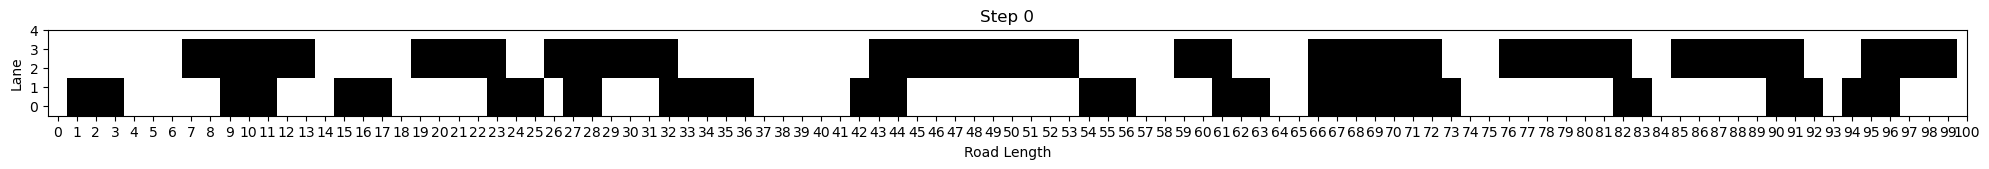

Vehicle 54 is at position 11, with a speed of 1 at row 0
Vehicle 55 is at position 33, with a speed of 0 at row 0
Vehicle 56 is at position 22, with a speed of 5 at row 2
Vehicle 57 is at position 32, with a speed of 0 at row 0
Vehicle 58 is at position 99, with a speed of 5 at row 2
Vehicle 59 is at position 30, with a speed of 4 at row 2
Vehicle 60 is at position 5, with a speed of 4 at row 0
Vehicle 61 is at position 38, with a speed of 5 at row 0
Vehicle 62 is at position 91, with a speed of 5 at row 2
Vehicle 63 is at position 66, with a speed of 5 at row 0
Vehicle 64 is at position 39, with a speed of 0 at row 0
Vehicle 65 is at position 77, with a speed of 4 at row 0
Vehicle 66 is at position 91, with a speed of 3 at row 0
Vehicle 67 is at position 96, with a speed of 5 at row 0
Vehicle 68 is at position 65, with a speed of 5 at row 2
Vehicle 69 is at position 4, with a speed of 5 at row 0
Vehicle 70 is at position 67, with a speed of 5 at row 0
Vehicle 71 is at position 73, wit

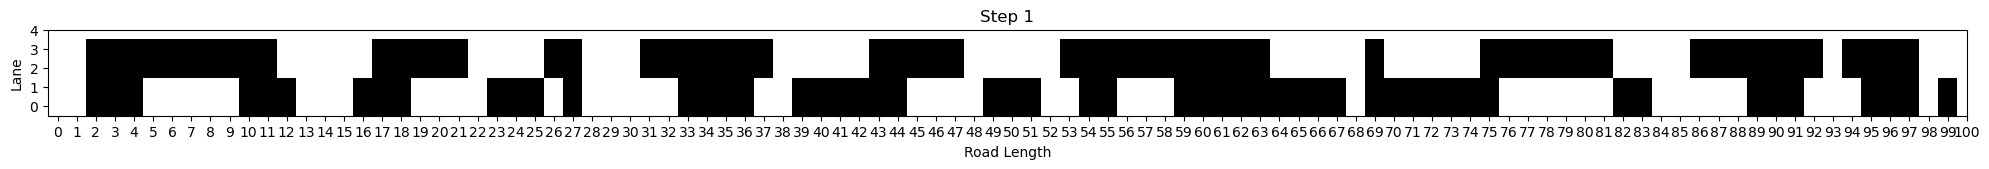

Vehicle 54 is at position 11, with a speed of 0 at row 0
Vehicle 55 is at position 35, with a speed of 1 at row 0
Vehicle 56 is at position 32, with a speed of 5 at row 2
Vehicle 57 is at position 34, with a speed of 1 at row 0
Vehicle 58 is at position 9, with a speed of 5 at row 2
Vehicle 59 is at position 40, with a speed of 5 at row 2
Vehicle 60 is at position 15, with a speed of 5 at row 0
Vehicle 61 is at position 48, with a speed of 5 at row 0
Vehicle 62 is at position 1, with a speed of 5 at row 2
Vehicle 63 is at position 76, with a speed of 5 at row 0
Vehicle 64 is at position 41, with a speed of 1 at row 0
Vehicle 65 is at position 87, with a speed of 5 at row 0
Vehicle 66 is at position 93, with a speed of 1 at row 0
Vehicle 67 is at position 6, with a speed of 5 at row 0
Vehicle 68 is at position 75, with a speed of 5 at row 2
Vehicle 69 is at position 14, with a speed of 5 at row 0
Vehicle 70 is at position 77, with a speed of 5 at row 0
Vehicle 71 is at position 77, with

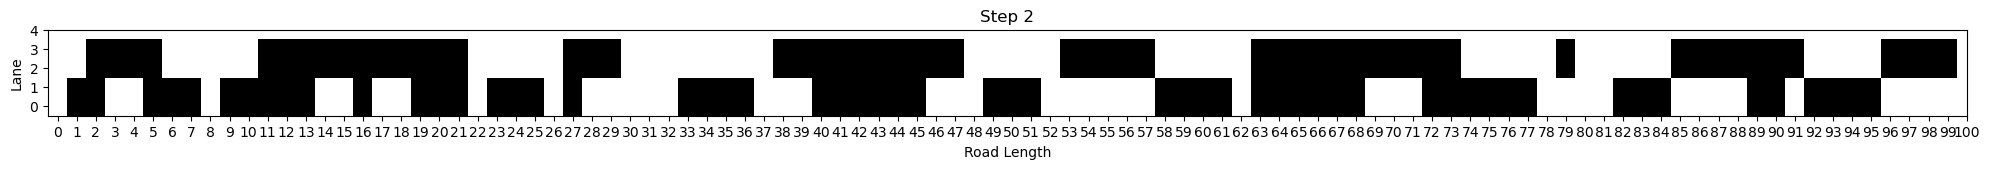

Vehicle 54 is at position 13, with a speed of 1 at row 0
Vehicle 55 is at position 39, with a speed of 2 at row 0
Vehicle 56 is at position 42, with a speed of 5 at row 2
Vehicle 57 is at position 38, with a speed of 2 at row 0
Vehicle 58 is at position 19, with a speed of 5 at row 2
Vehicle 59 is at position 50, with a speed of 5 at row 2
Vehicle 60 is at position 25, with a speed of 5 at row 0
Vehicle 61 is at position 58, with a speed of 5 at row 0
Vehicle 62 is at position 11, with a speed of 5 at row 2
Vehicle 63 is at position 86, with a speed of 5 at row 0
Vehicle 64 is at position 41, with a speed of 0 at row 0
Vehicle 65 is at position 97, with a speed of 5 at row 0
Vehicle 66 is at position 97, with a speed of 2 at row 0
Vehicle 67 is at position 16, with a speed of 5 at row 0
Vehicle 68 is at position 85, with a speed of 5 at row 2
Vehicle 69 is at position 24, with a speed of 5 at row 0
Vehicle 70 is at position 87, with a speed of 5 at row 0
Vehicle 71 is at position 83, w

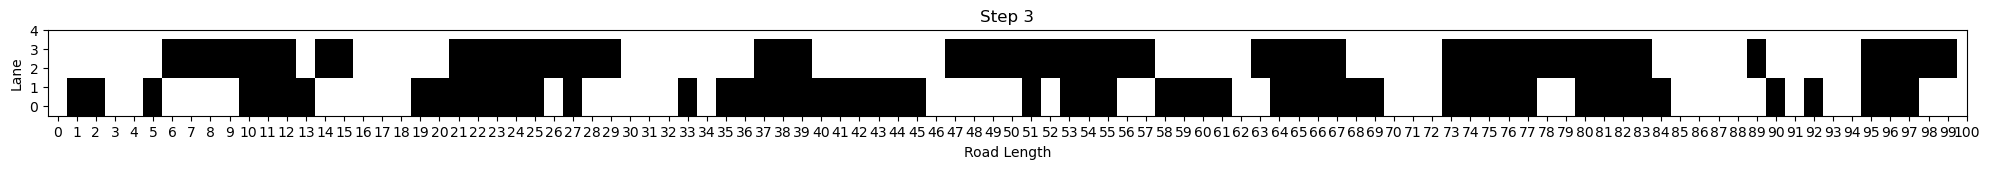

Vehicle 54 is at position 17, with a speed of 2 at row 0
Vehicle 55 is at position 39, with a speed of 0 at row 0
Vehicle 56 is at position 52, with a speed of 5 at row 2
Vehicle 57 is at position 44, with a speed of 3 at row 0
Vehicle 58 is at position 29, with a speed of 5 at row 2
Vehicle 59 is at position 60, with a speed of 5 at row 2
Vehicle 60 is at position 35, with a speed of 5 at row 0
Vehicle 61 is at position 68, with a speed of 5 at row 0
Vehicle 62 is at position 21, with a speed of 5 at row 2
Vehicle 63 is at position 96, with a speed of 5 at row 0
Vehicle 64 is at position 41, with a speed of 0 at row 0
Vehicle 65 is at position 7, with a speed of 5 at row 0
Vehicle 66 is at position 3, with a speed of 3 at row 0
Vehicle 67 is at position 26, with a speed of 5 at row 0
Vehicle 68 is at position 95, with a speed of 5 at row 2
Vehicle 69 is at position 34, with a speed of 5 at row 0
Vehicle 70 is at position 97, with a speed of 5 at row 0
Vehicle 71 is at position 83, wit

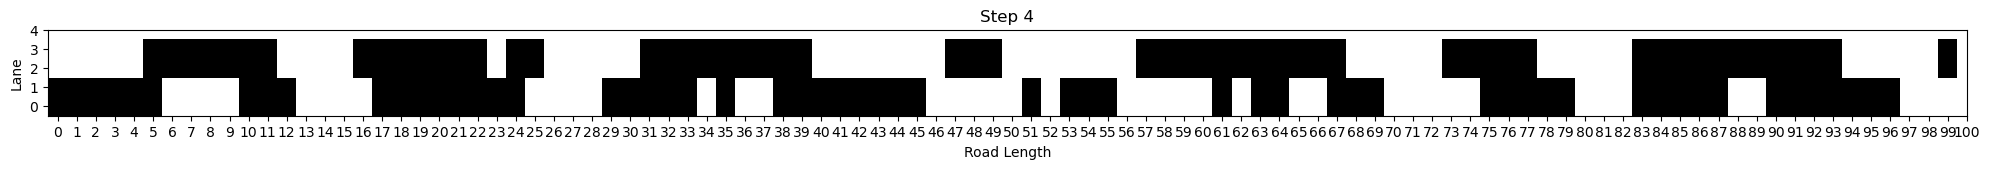

Vehicle 54 is at position 23, with a speed of 3 at row 0
Vehicle 55 is at position 39, with a speed of 0 at row 0
Vehicle 56 is at position 62, with a speed of 5 at row 2
Vehicle 57 is at position 52, with a speed of 4 at row 0
Vehicle 58 is at position 39, with a speed of 5 at row 2
Vehicle 59 is at position 70, with a speed of 5 at row 2
Vehicle 60 is at position 45, with a speed of 5 at row 0
Vehicle 61 is at position 78, with a speed of 5 at row 0
Vehicle 62 is at position 31, with a speed of 5 at row 2
Vehicle 63 is at position 6, with a speed of 5 at row 0
Vehicle 64 is at position 41, with a speed of 0 at row 0
Vehicle 65 is at position 17, with a speed of 5 at row 0
Vehicle 66 is at position 11, with a speed of 4 at row 0
Vehicle 67 is at position 36, with a speed of 5 at row 0
Vehicle 68 is at position 5, with a speed of 5 at row 2
Vehicle 69 is at position 44, with a speed of 5 at row 0
Vehicle 70 is at position 7, with a speed of 5 at row 0
Vehicle 71 is at position 85, with

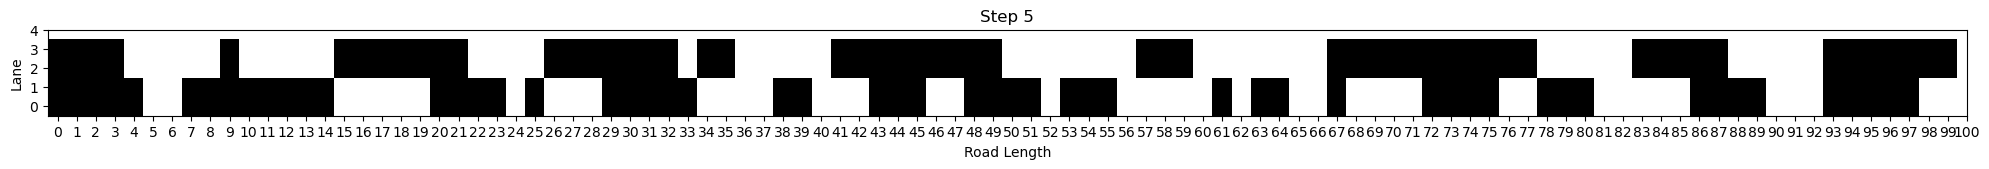

Vehicle 54 is at position 31, with a speed of 4 at row 0
Vehicle 55 is at position 41, with a speed of 1 at row 0
Vehicle 56 is at position 72, with a speed of 5 at row 2
Vehicle 57 is at position 52, with a speed of 0 at row 0
Vehicle 58 is at position 49, with a speed of 5 at row 2
Vehicle 59 is at position 80, with a speed of 5 at row 2
Vehicle 60 is at position 55, with a speed of 5 at row 0
Vehicle 61 is at position 88, with a speed of 5 at row 0
Vehicle 62 is at position 41, with a speed of 5 at row 2
Vehicle 63 is at position 16, with a speed of 5 at row 0
Vehicle 64 is at position 43, with a speed of 1 at row 0
Vehicle 65 is at position 27, with a speed of 5 at row 0
Vehicle 66 is at position 11, with a speed of 0 at row 0
Vehicle 67 is at position 46, with a speed of 5 at row 0
Vehicle 68 is at position 15, with a speed of 5 at row 2
Vehicle 69 is at position 54, with a speed of 5 at row 0
Vehicle 70 is at position 17, with a speed of 5 at row 0
Vehicle 71 is at position 89, w

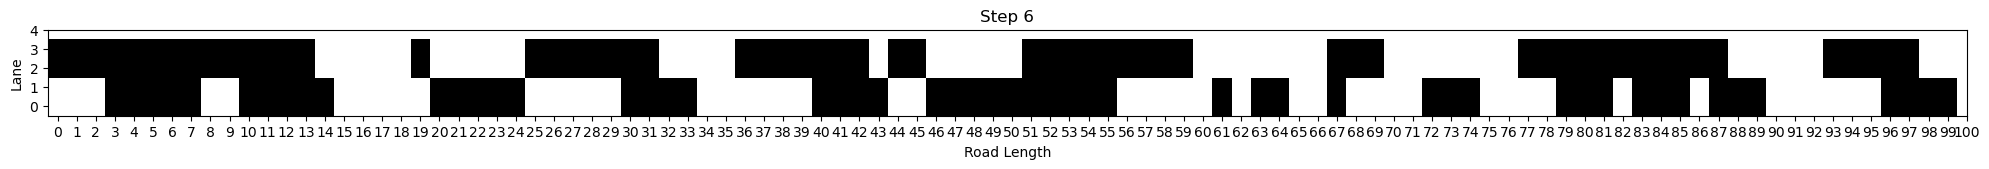

Vehicle 54 is at position 31, with a speed of 0 at row 0
Vehicle 55 is at position 45, with a speed of 2 at row 0
Vehicle 56 is at position 82, with a speed of 5 at row 2
Vehicle 57 is at position 54, with a speed of 1 at row 0
Vehicle 58 is at position 59, with a speed of 5 at row 2
Vehicle 59 is at position 90, with a speed of 5 at row 2
Vehicle 60 is at position 65, with a speed of 5 at row 0
Vehicle 61 is at position 98, with a speed of 5 at row 0
Vehicle 62 is at position 51, with a speed of 5 at row 2
Vehicle 63 is at position 26, with a speed of 5 at row 0
Vehicle 64 is at position 47, with a speed of 2 at row 0
Vehicle 65 is at position 37, with a speed of 5 at row 0
Vehicle 66 is at position 13, with a speed of 1 at row 0
Vehicle 67 is at position 56, with a speed of 5 at row 0
Vehicle 68 is at position 25, with a speed of 5 at row 2
Vehicle 69 is at position 64, with a speed of 5 at row 0
Vehicle 70 is at position 27, with a speed of 5 at row 0
Vehicle 71 is at position 95, w

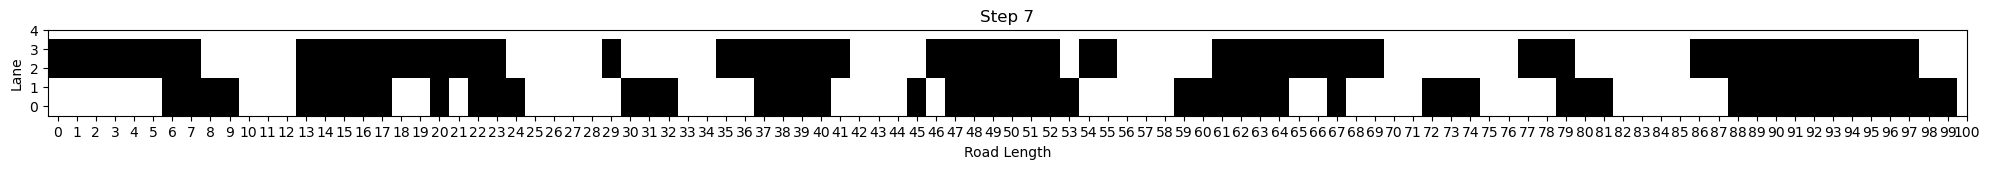

Vehicle 54 is at position 31, with a speed of 0 at row 0
Vehicle 55 is at position 51, with a speed of 3 at row 0
Vehicle 56 is at position 92, with a speed of 5 at row 2
Vehicle 57 is at position 58, with a speed of 2 at row 0
Vehicle 58 is at position 69, with a speed of 5 at row 2
Vehicle 59 is at position 0, with a speed of 5 at row 2
Vehicle 60 is at position 75, with a speed of 5 at row 0
Vehicle 61 is at position 8, with a speed of 5 at row 0
Vehicle 62 is at position 61, with a speed of 5 at row 2
Vehicle 63 is at position 36, with a speed of 5 at row 0
Vehicle 64 is at position 53, with a speed of 3 at row 0
Vehicle 65 is at position 47, with a speed of 5 at row 0
Vehicle 66 is at position 17, with a speed of 2 at row 0
Vehicle 67 is at position 66, with a speed of 5 at row 0
Vehicle 68 is at position 35, with a speed of 5 at row 2
Vehicle 69 is at position 74, with a speed of 5 at row 0
Vehicle 70 is at position 37, with a speed of 5 at row 0
Vehicle 71 is at position 3, with

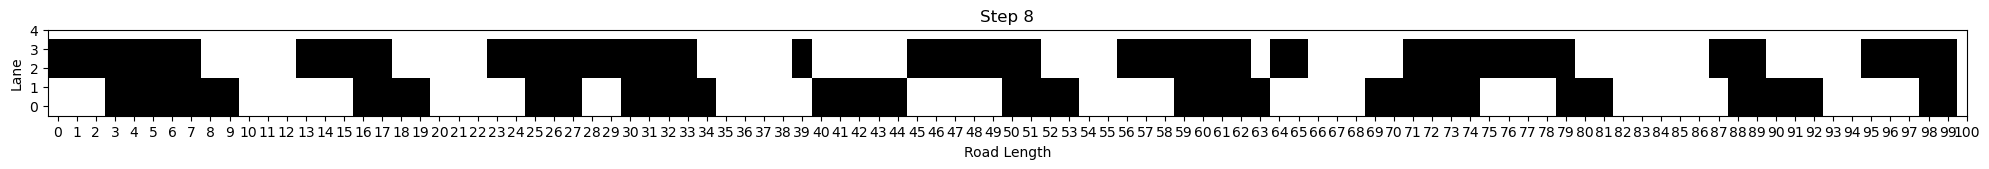

Vehicle 54 is at position 33, with a speed of 1 at row 0
Vehicle 55 is at position 51, with a speed of 0 at row 0
Vehicle 56 is at position 2, with a speed of 5 at row 2
Vehicle 57 is at position 64, with a speed of 3 at row 0
Vehicle 58 is at position 79, with a speed of 5 at row 2
Vehicle 59 is at position 10, with a speed of 5 at row 2
Vehicle 60 is at position 85, with a speed of 5 at row 0
Vehicle 61 is at position 18, with a speed of 5 at row 0
Vehicle 62 is at position 71, with a speed of 5 at row 2
Vehicle 63 is at position 46, with a speed of 5 at row 0
Vehicle 64 is at position 61, with a speed of 4 at row 0
Vehicle 65 is at position 57, with a speed of 5 at row 0
Vehicle 66 is at position 17, with a speed of 0 at row 0
Vehicle 67 is at position 76, with a speed of 5 at row 0
Vehicle 68 is at position 45, with a speed of 5 at row 2
Vehicle 69 is at position 84, with a speed of 5 at row 0
Vehicle 70 is at position 47, with a speed of 5 at row 0
Vehicle 71 is at position 13, wi

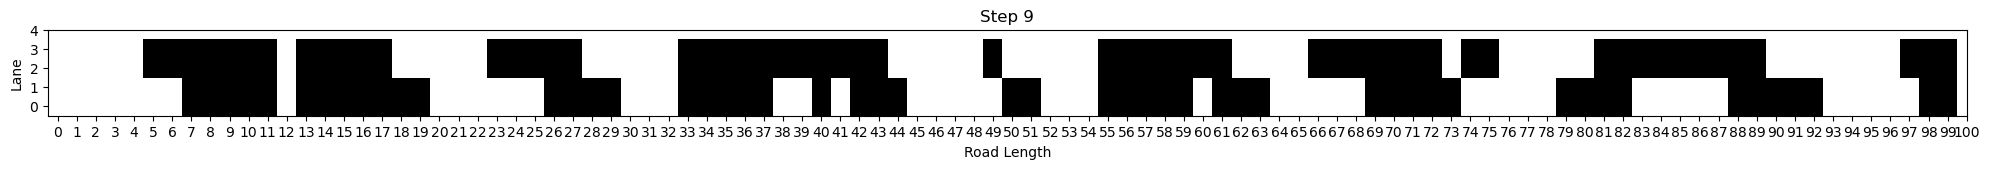

In [131]:
road = Road(road_length=100, road_width=4, speed_limit=5)
simulator = IntraRoadSimulator(road)

density = 1  # Example density
truck_fraction = 0.3 # Example truck fraction
simulator.initialize_vehicles(density, truck_fraction, 0.3, 0)
for step in range(10):
    simulator.simulation_step()
    if step % 1 == 0:
        simulator.visualize(step)

MOVING CHECKER

Vehicle 26 is at position 48, with a speed of 5 at row 0
Vehicle 27 is at position 65, with a speed of 0 at row 0
Vehicle 28 is at position 176, with a speed of 0 at row 0
Vehicle 29 is at position 197, with a speed of 0 at row 0
Vehicle 30 is at position 21, with a speed of 0 at row 0
Vehicle 31 is at position 121, with a speed of 5 at row 0
Vehicle 32 is at position 129, with a speed of 3 at row 0
Vehicle 33 is at position 53, with a speed of 5 at row 0
Vehicle 34 is at position 108, with a speed of 0 at row 0
Vehicle 35 is at position 124, with a speed of 5 at row 0
Vehicle 36 is at position 173, with a speed of 4 at row 2
Vehicle 37 is at position 137, with a speed of 5 at row 0
Vehicle 38 is at position 141, with a speed of 0 at row 0
Vehicle 39 is at position 150, with a speed of 0 at row 0
Vehicle 40 is at position 17, with a speed of 2 at row 2
Vehicle 41 is at position 43, with a speed of 5 at row 0
Vehicle 42 is at position 92, with a speed of 5 at row 0
Vehicle 43 is at posi

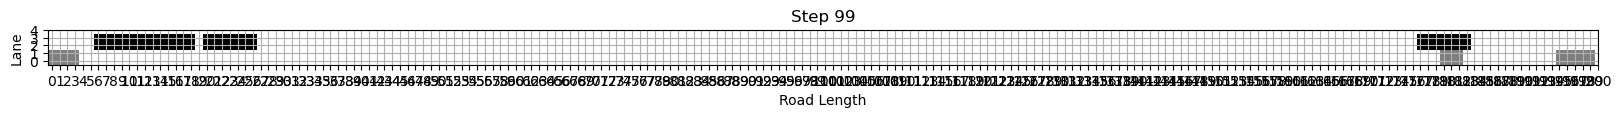

In [120]:
def animate(step):
    simulator.simulation_step()  # Run a simulation step
    ax.clear()  # Clear the previous plot
    ax.imshow(simulator.road.road_occupancy.T, cmap='gray_r', origin='lower')
    ax.set_title(f'Step {step}')
    ax.set_xlabel('Road Length')
    ax.set_ylabel('Lane')
    ax.set_xticks(range(0, simulator.road.road_length + 1, 1))
    ax.set_yticks(range(0, simulator.road.road_width + 1, 1))
    ax.grid(True)

# Initialize road and simulator
road = Road(road_length=200, road_width=4, speed_limit=5)
simulator = IntraRoadSimulator(road)

density = 1
truck_fraction = 0.1

simulator.initialize_vehicles(density, truck_fraction, 1, 0)  # Initialize vehicles

# Set up the figure and axis for animation
fig, ax = plt.subplots(figsize=(20, 6))

# Create the animation
anim = FuncAnimation(fig, animate, frames=100, interval=200)

# Save the animation as a GIF or MP4
anim.save('road_simulation_vehicle_only.gif', writer='pillow')
# Or save as MP4
# anim.save('road_simulation.mp4', writer='ffmpeg')

# Show the animation in a Jupyter notebook (if using one)
plt.show()

In [24]:
# Define the density values you want to test
density_values = np.linspace(0, 1, 20)  # Example: 8 density points from 0.05 to 0.4
timesteps = 1000
truck_fraction = 0.3

# Create a directory to store the CSV files
output_dir = "density_timesteps_output2"
os.makedirs(output_dir, exist_ok=True)

for density in density_values:
    road = Road(road_length=200, road_width=4, speed_limit=5)
    simulator = IntraRoadSimulator(road)
    simulator.initialize_vehicles(density, truck_fraction, 1, 0)
    
    csv_filename = os.path.join(output_dir, f'density_{density:.2f}.csv')
    
    # Open the CSV file for writing
    with open(csv_filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Timestep", "Throughput"])
        
        for step in range(timesteps):
            simulator.simulation_step(density, truck_fraction)
            throughput_at_step = simulator.vehicle_throughput
            writer.writerow([step + 1, throughput_at_step])
            
    print(f'Saved: {csv_filename}')

print("CSV files for all densities and timesteps have been saved.")

Saved: density_timesteps_output2/density_0.00.csv
Saved: density_timesteps_output2/density_0.05.csv
Saved: density_timesteps_output2/density_0.11.csv
Saved: density_timesteps_output2/density_0.16.csv
Saved: density_timesteps_output2/density_0.21.csv
Saved: density_timesteps_output2/density_0.26.csv
Saved: density_timesteps_output2/density_0.32.csv
Saved: density_timesteps_output2/density_0.37.csv
Saved: density_timesteps_output2/density_0.42.csv
Saved: density_timesteps_output2/density_0.47.csv
Saved: density_timesteps_output2/density_0.53.csv
Saved: density_timesteps_output2/density_0.58.csv
Saved: density_timesteps_output2/density_0.63.csv
Saved: density_timesteps_output2/density_0.68.csv
Saved: density_timesteps_output2/density_0.74.csv
Saved: density_timesteps_output2/density_0.79.csv
Saved: density_timesteps_output2/density_0.84.csv
Saved: density_timesteps_output2/density_0.89.csv
Saved: density_timesteps_output2/density_0.95.csv
Saved: density_timesteps_output2/density_1.00.csv
